# Japanese Food Culture Classification



In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
CSV_URL = "https://www.nstac.go.jp/sys/files//SSDSE-C-2022.csv"

df = pd.read_csv(CSV_URL, encoding = "shift-jis")
df.head()

,SSDSE-C-2022,Prefecture,City,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
0,地域コード,都道府県,市,世帯人員,食料（合計）,01 穀類,米,食パン,他のパン,生うどん・そば,...,すし（外食）,和食,中華食,洋食,焼肉,ハンバーガー,他の主食的外食,喫茶代,飲酒代,学校給食
1,R00000,全国,全国,2.95,960240,79678,22998,10163,21494,3513,...,13620,19716,4179,9794,6184,5067,44164,6522,11358,9713
2,R01100,北海道,札幌市,2.84,942332,82566,29665,9367,18496,3214,...,16906,22845,3772,15761,7132,4187,20326,5462,14817,13273
3,R02201,青森県,青森市,2.87,892205,73320,21932,8285,17063,3164,...,12594,13802,2748,6796,5794,3991,14162,2833,6874,9698
4,R03201,岩手県,盛岡市,3.12,937554,79379,23297,8402,20278,3435,...,11490,9847,1826,5333,4951,3884,35759,4046,11100,10647


In [3]:
# only left tertiary items
drop_items = [
    "City", # 市
    "LB00", # 食料（合計）
    "LB01", # 01　穀類
    "LB012002", # 他のパン
    "LB013007", # 他の麺類
    "LB014003", # 他の穀類のその他
    "LB02", # 02　魚介類
    "LB021115", # 他の鮮魚
    "LB021116", # さしみ盛合わせ
    "LB023004", # 他の魚肉練製品
    "LB024005", # 他の魚介加工品のその他
    "LB03", # 03　肉類
    "LB031005", # 他の生鮮肉
    "LB032004", # 他の加工肉
    "LB04", # 04　乳卵類
    "LB042005", # 他の乳製品
    "LB05", # 05　野菜・海藻
    "LB051108", # 他の葉茎菜
    "LB051310", # 他のきのこ
    "LB051311", # 他の野菜のその他
    "LB052006", # 他の乾物・海藻
    "LB053004", # 他の大豆製品
    "LB054005", # 他の野菜の漬物
    "LB054007", # 他の野菜・海藻の佃煮
    "LB054008", # 他の野菜・海藻加工品のその他
    "LB06", # 06　果物
    "LB061005", # 他の柑きつ類
    "LB061015", # 他の果物
    "LB062001", # 果物加工品
    "LB07", # 07　油脂・調味料
    "LB072016", # 他の調味料
    "LB08", # 08　菓子類
    "LB080003", # 他の和生菓子
    "LB080008", # 他の洋生菓子
    "LB080016", # 他の菓子
    "LB09", # 09　調理食品
    "LB091001", # 弁当
    "LB091004", # 調理パン
    "LB091005", # 他の主食的調理食品
    "LB092010", # 冷凍調理食品
    "LB092011", # そうざい材料セット
    "LB092012", # 他の調理食品のその他
    "LB10", # 10　飲料
    "LB101003", # 他の茶葉
    "LB103007", # 他の飲料のその他
    "LB11", # 11　酒類
    "LB110008", # 他の酒
    "LB12", # 12　外食
    "LB121103", # 他の麺類外食
    "LB121110", # 他の主食的外食
    "LB121201", # 喫茶代
    "LB121202", # 飲酒代
    "LB122001" # 学校給食
]
df = df.drop(drop_items, axis=1)

rowid_and_pref = [
    "SSDSE-C-2022",
    "Prefecture"   
]
rowid_pref_df = df[rowid_and_pref]
colid_label_df = df.iloc[0]

df = df.drop([0, 1], axis=0)
df = df.set_index("SSDSE-C-2022")
df = df.drop(["Prefecture"], axis=1)
df = df.astype("float32") # convert int to float

In [4]:
df.head()

,LA03,LB011001,LB012001,LB013001,LB013002,LB013003,LB013004,LB013005,LB013006,LB014001,...,LB110006,LB110007,LB121101,LB121102,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109
SSDSE-C-2022,,,,,,,,,,,,,,,,,,,,,
R01100,2.84,29665.0,9367.0,3214.0,2113.0,1280.0,4360.0,5494.0,1754.0,680.0,...,12761.0,4638.0,5581.0,6695.0,16906.0,22845.0,3772.0,15761.0,7132.0,4187.0
R02201,2.87,21932.0,8285.0,3164.0,2258.0,1196.0,5592.0,6399.0,2181.0,661.0,...,14825.0,6063.0,4605.0,9508.0,12594.0,13802.0,2748.0,6796.0,5794.0,3991.0
R03201,3.12,23297.0,8402.0,3435.0,2199.0,1302.0,6223.0,6229.0,1883.0,693.0,...,12982.0,5829.0,5453.0,8551.0,11490.0,9847.0,1826.0,5333.0,4951.0,3884.0
R04100,3.00,20686.0,8875.0,3128.0,2051.0,1343.0,4985.0,5902.0,1962.0,651.0,...,8057.0,3544.0,6575.0,9333.0,12384.0,16022.0,2890.0,7540.0,6073.0,4585.0
R05201,2.72,20219.0,7398.0,3241.0,4161.0,1026.0,5479.0,5014.0,1796.0,526.0,...,12222.0,5305.0,5717.0,8927.0,14497.0,14451.0,2541.0,5430.0,7340.0,3014.0


In [5]:
number_of_households = "LA03"

personal_df = df.div(df[number_of_households], axis=0)
personal_df = personal_df.drop([number_of_households], axis=1)

personal_df.head()

,LB011001,LB012001,LB013001,LB013002,LB013003,LB013004,LB013005,LB013006,LB014001,LB014002,...,LB110006,LB110007,LB121101,LB121102,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109
SSDSE-C-2022,,,,,,,,,,,,,,,,,,,,,
R01100,10445.422852,3298.239502,1131.690186,744.014099,450.704254,1535.211304,1934.507080,617.605652,239.436630,647.183105,...,4493.310059,1633.098633,1965.140869,2357.394531,5952.816895,8044.014160,1328.169067,5549.647949,2511.267578,1474.295776
R02201,7641.812012,2886.759766,1102.439087,786.759644,416.724762,1948.432129,2229.616699,759.930359,230.313599,450.174225,...,5165.505371,2112.543701,1604.529663,3312.892090,4388.153320,4809.059570,957.491333,2367.944336,2018.815430,1390.592407
R03201,7466.987305,2692.948730,1100.961548,704.807739,417.307709,1994.551392,1996.474487,603.525635,222.115387,440.384644,...,4160.897461,1868.269287,1747.756470,2740.705322,3682.692383,3156.089844,585.256409,1709.294922,1586.859009,1244.871826
R04100,6895.333496,2958.333252,1042.666626,683.666687,447.666656,1661.666626,1967.333374,654.000000,217.000000,523.000000,...,2685.666748,1181.333374,2191.666748,3111.000000,4128.000000,5340.666504,963.333313,2513.333252,2024.333374,1528.333374
R05201,7433.455566,2719.853027,1191.544067,1529.779419,377.205872,2014.338257,1843.382324,660.294128,193.382355,472.794098,...,4493.382324,1950.367676,2101.838135,3281.985352,5329.779297,5312.867676,934.191162,1996.323486,2698.529297,1108.088257


In [41]:
n_clusters = range(2, 10)
models = []
for n in n_clusters:
    _X = StandardScaler().fit_transform(personal_df)
    model = KMeans(n).fit(_X)
    models.append(model)

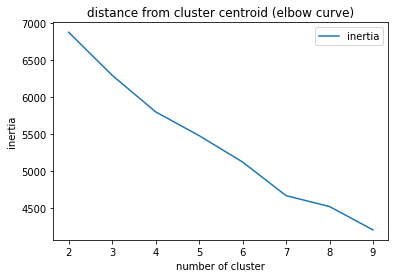

In [42]:
plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('inertia')
plt.plot(list(n_clusters), [m.inertia_ for m in models],label='inertia')
plt.legend()
plt.show()

In [43]:
model = None
target_n_clusters = 7
wcss_bar = 0
for trial in range(100):
    _X = StandardScaler().fit_transform(personal_df)
    _model = KMeans(target_n_clusters).fit(_X)
    if model is None or _model.inertia_ < wcss_bar:
        model = _model
        wcss_bar = _model.inertia_

In [44]:
cluster_df = pd.merge(
    personal_df.assign(Cluster=model.labels_),
    rowid_pref_df.set_index("SSDSE-C-2022"),
    left_index=True,
    right_index=True
)
cluster_df.sort_values("Cluster")[["Cluster", "Prefecture"]]

,Cluster,Prefecture
SSDSE-C-2022,,
R39201,0,高知県
R33100,0,岡山県
R35203,0,山口県
R36201,0,徳島県
R37201,0,香川県
R38201,0,愛媛県
R31201,0,鳥取県
R30201,0,和歌山県
R32201,1,島根県


In [46]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
])

pipeline.fit(cluster_df.drop(columns=["Prefecture", "Cluster"]), cluster_df["Cluster"])

importance_df = pd.DataFrame({
    "importance": np.round(pipeline["model"].feature_importances_, 3),
    "id": pipeline[:-1].get_feature_names_out(),
    "name": colid_label_df[pipeline[:-1].get_feature_names_out()]
})

importance_df.sort_values("importance", ascending=False)

,importance,id,name
LB031004,0.034,LB031004,合いびき肉
LB024002,0.032,LB024002,魚介の漬物
LB024004,0.032,LB024004,魚介の缶詰
LB092006,0.030,LB092006,しゅうまい
LB053003,0.027,LB053003,納豆
...,...,...,...
LB061011,0.000,LB061011,メロン
LB051308,0.000,LB051308,しめじ
LB051209,0.000,LB051209,たけのこ
LB051202,0.000,LB051202,じゃがいも
